# Convert ns-ALEX pt3 files to Photon-HDF5

In [2]:
filename = 'data/Point_A2_000mV(7)_60.5__30s_1.pt3'

In [3]:
from __future__ import print_function, division
from past.builtins import xrange
from builtins import zip

import os
import struct
import time
from collections import OrderedDict
import numpy as np

In [4]:
%matplotlib inline
import numpy as np
import phconvert as phc
print('phconvert version: ' + phc.__version__)

phconvert version: 0+unknown


In [5]:
def pt3_reader(filename):
    """Load raw t3 records and metadata from a PT3 file.
    """
    with open(filename, 'rb') as f:
        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        # Binary file header
        header_dtype = np.dtype([
            ('Ident',             'S16'   ),
            ('FormatVersion',     'S6'    ),
            ('CreatorName',       'S18'   ),
            ('CreatorVersion',    'S12'   ),
            ('FileTime',          'S18'   ),
            ('CRLF',              'S2'    ),
            ('Comment',           'S256'  ),
            ('NumberOfCurves',    'int32' ),
            ('BitsPerRecord',     'int32' ),   # bits in each T3 record
            ('RoutingChannels',   'int32' ),
            ('NumberOfBoards',    'int32' ),
            ('ActiveCurve',       'int32' ),
            ('MeasurementMode',   'int32' ),
            ('SubMode',           'int32' ),
            ('RangeNo',           'int32' ),
            ('Offset',            'int32' ),
            ('AcquisitionTime',   'int32' ),   # in ms
            ('StopAt',            'uint32'),
            ('StopOnOvfl',        'int32' ),
            ('Restart',           'int32' ),
            ('DispLinLog',        'int32' ),
            ('DispTimeAxisFrom',  'int32' ),
            ('DispTimeAxisTo',    'int32' ),
            ('DispCountAxisFrom', 'int32' ),
            ('DispCountAxisTo',   'int32' ),
        ])
        header = np.fromfile(f, dtype=header_dtype, count=1)

        if header['FormatVersion'][0] != b'2.0':
            raise IOError(("Format '%s' not supported. "
                           "Only valid format is '2.0'.") % \
                           header['FormatVersion'][0])

        dispcurve_dtype = np.dtype([
            ('DispCurveMapTo', 'int32'),
            ('DispCurveShow',  'int32')])
        dispcurve = np.fromfile(f, dispcurve_dtype, count=8)

        params_dtype = np.dtype([
            ('ParamStart', 'f4'),
            ('ParamStep',  'f4'),
            ('ParamEnd',   'f4')])
        params = np.fromfile(f, params_dtype, count=3)

        repeat_dtype = np.dtype([
            ('RepeatMode',      'int32'),
            ('RepeatsPerCurve', 'int32'),
            ('RepeatTime',       'int32'),
            ('RepeatWaitTime',  'int32'),
            ('ScriptName',      'S20'  )])
        repeatgroup = np.fromfile(f, repeat_dtype, count=1)

        # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
        # Hardware information header
        hw_dtype = np.dtype([
            ('HardwareIdent',   'S16'  ),
            ('HardwarePartNo',  'S8'   ),
            ('HardwareSerial',  'int32'),
            ('SyncDivider',     'int32'),
            ('CFDZeroCross0',   'int32'),
            ('CFDLevel0',       'int32'),
            ('CFDZeroCross1',   'int32'),
            ('CFDLevel1',       'int32'),
            ('Resolution',      'f4'),
            ('RouterModelCode', 'int32'),
            ('RouterEnabled',   'int32')])
        hardware = np.fromfile(f, hw_dtype, count=1)

        rtr_dtype = np.dtype([
            ('InputType',       'int32'),
            ('InputLevel',      'int32'),
            ('InputEdge',       'int32'),
            ('CFDPresent',      'int32'),
            ('CFDLevel',        'int32'),
            ('CFDZCross',       'int32')])
        router = np.fromfile(f, rtr_dtype, count=4)

        # Time tagging mode specific header
        ttmode_dtype = np.dtype([
            ('ExtDevices',      'int32' ),
            ('Reserved1',       'int32' ),
            ('Reserved2',       'int32' ),
            ('InpRate0',        'int32' ),
            ('InpRate1',        'int32' ),
            ('StopAfter',       'int32' ),
            ('StopReason',      'int32' ),
            ('nRecords',        'int32' ),
            ('ImgHdrSize',      'int32')])
        ttmode = np.fromfile(f, ttmode_dtype, count=1)

        # Special header for imaging. How many of the following ImgHdr
        # array elements are actually present in the file is indicated by
        # ImgHdrSize above.
        ImgHdr = np.fromfile(f, dtype='int32', count=ttmode['ImgHdrSize'])

        # The remainings are all T3 records
        t3records = np.fromfile(f, dtype='uint32', count=ttmode['nRecords'])

        timestamps_unit = 1./ttmode['InpRate0']
        nanotimes_unit = 1e-9*hardware['Resolution']

        metadata = dict(header=header, dispcurve=dispcurve, params=params,
                        repeatgroup=repeatgroup, hardware=hardware,
                        router=router, ttmode=ttmode, imghdr=ImgHdr)
        return t3records, timestamps_unit, nanotimes_unit, metadata

In [6]:
t3records, timestamps_unit, nanotimes_unit, metadata = pt3_reader(filename)

/home/biswajit/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:101: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/biswajit/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:104: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [7]:
photton_arrival =t3records * timestamps_unit;


In [8]:
np.shape(t3records)

(63092,)

In [9]:
import os
try: 
    with open(filename): pass
    print('Data file found, you can proceed.')
except IOError:
    print('ATTENTION: Data file not found, please check the filename.\n'
          '           (current value "%s")' % filename)

Data file found, you can proceed.


## Load Data

In [10]:
%matplotlib inline
import numpy as np
import phconvert as phc
print('phconvert version: ' + phc.__version__)

phconvert version: 0+unknown


In [11]:
d, meta = phc.loader.nsalex_pt3(filename,
                                donor = 1,
                                acceptor = 0,
                                alex_period_donor = (4000, 5000),
                                alex_period_acceptor = (0, 3000),
                                excitation_wavelengths = (470e-9, 635e-9),
                                detection_wavelengths = (525e-9, 690e-9),
                                )

 - Loading 'data/Point_A2_000mV(7)_60.5__30s_1.pt3' ... 
 [DONE]



/home/biswajit/anaconda3/lib/python3.6/site-packages/phconvert-0+unknown-py3.6.egg/phconvert/pqreader.py:391: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  ImgHdr = np.fromfile(f, dtype='int32', count=ttmode['ImgHdrSize'])
/home/biswajit/anaconda3/lib/python3.6/site-packages/phconvert-0+unknown-py3.6.egg/phconvert/pqreader.py:394: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  t3records = np.fromfile(f, dtype='uint32', count=ttmode['nRecords'])


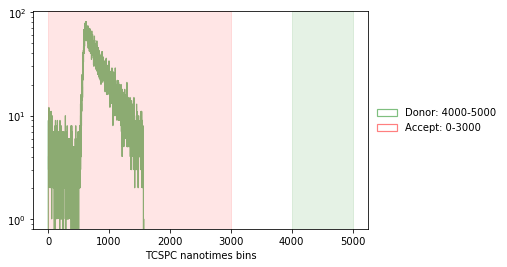

In [12]:
phc.plotter.alternation_hist(d)

In [13]:
detectors = d['photon_data']['detectors']

print("Detector    Counts")
print("--------   --------")
for det, count in zip(*np.unique(detectors, return_counts=True)):
    print("%8d   %8d" % (det, count))

Detector    Counts
--------   --------
       1      26475
      15      36617


## Removing the overflow counts

In [14]:
nanotimes = d['photon_data']['nanotimes']
detectors = d['photon_data']['detectors']
timestamps = d['photon_data']['timestamps']

overflow_nanotimes = d['photon_data']['nanotimes'] != 0

detectors = detectors[overflow_nanotimes]
timestamps = timestamps[overflow_nanotimes]
nanotimes = nanotimes[overflow_nanotimes]

In [15]:
print("Detector    Counts")
print("--------   --------")
for det, count in zip(*np.unique(detectors, return_counts=True)):
    print("%8d   %8d" % (det, count))

Detector    Counts
--------   --------
       1      26471


In [16]:
d['photon_data']['nanotimes'] = nanotimes
d['photon_data']['detectors'] = detectors
d['photon_data']['timestamps'] = timestamps

## Metadata

In [17]:
author = 'Biswajit'
author_affiliation = 'Leiden University'
description = 'A demonstrative pt3 data readin.'
sample_name = 'ttttt'
dye_names = 'ATTO655'
buffer_name = 'HEPES pH7 with 100 mM NaCl'

### Add meta data

In [18]:
d['description'] = description

d['sample'] = dict(
    sample_name=sample_name,
    dye_names=dye_names,
    buffer_name=buffer_name,
    num_dyes = len(dye_names.split(',')))

d['identity'] = dict(
    author=author,
    author_affiliation=author_affiliation)

In [19]:
# Remove some empty groups that may cause errors on saving
_ = meta.pop('dispcurve', None)
_ = meta.pop('imghdr', None)

In [20]:
d['user'] = {'picoquant': meta}

## Save to Photon-HDF5

In [21]:
phc.hdf5.save_photon_hdf5(d, overwrite=True)

Saving: data/Point_A2_000mV(7)_60.5__30s_1.hdf5


## Load Photon-HDF5

In [17]:
from pprint import pprint

In [18]:
filename = d['_data_file'].filename

In [19]:
h5data = phc.hdf5.load_photon_hdf5(filename)

In [20]:
phc.hdf5.dict_from_group(h5data.identity)

{'author': 'Biswajit',
 'author_affiliation': 'Leiden University',
 'creation_time': '2017-08-29 10:40:12',
 'filename': 'Point_A2_000mV(7)_60.5__30s_1.hdf5',
 'filename_full': '/home/biswajit/Research/Experimental/Analysis/Histogram_simulation/Python_simulation_Biswajit/photon_simulation/phconvert-outcome/notebook-Biswajit/data/Point_A2_000mV(7)_60.5__30s_1.hdf5',
 'format_name': 'Photon-HDF5',
 'format_url': 'http://photon-hdf5.org/',
 'format_version': '0.4',
 'software': 'phconvert',
 'software_version': '0+unknown'}

In [21]:
phc.hdf5.dict_from_group(h5data.setup)

{'detection_wavelengths': array([  5.25000000e-07,   6.90000000e-07]),
 'excitation_cw': array([0, 0], dtype=uint8),
 'excitation_wavelengths': array([  4.70000000e-07,   6.35000000e-07]),
 'lifetime': 1,
 'modulated_excitation': 1,
 'num_pixels': 2,
 'num_polarization_ch': 1,
 'num_spectral_ch': 2,
 'num_split_ch': 1,
 'num_spots': 1}

In [22]:
pprint(phc.hdf5.dict_from_group(h5data.photon_data))

{'detectors': array([1, 1, 1, ..., 1, 1, 1], dtype=uint8),
 'measurement_specs': {'alex_excitation_period1': [4000, 5000],
                       'alex_excitation_period2': [0, 3000],
                       'detectors_specs': {'spectral_ch1': array([1], dtype=uint8),
                                           'spectral_ch2': array([0], dtype=uint8)},
                       'laser_repetition_rate': 79999615.0,
                       'measurement_type': 'smFRET-nsALEX'},
 'nanotimes': array([1126,  540,  725, ..., 1010,  861,  858], dtype=uint16),
 'nanotimes_specs': {'tcspc_num_bins': 4096,
                     'tcspc_range': 3.2767999869065534e-08,
                     'tcspc_unit': 7.999999968033578e-12},
 'timestamps': array([   1082643,    1088445,    1424057, ..., 2398245738, 2398941826,
       2399364565]),
 'timestamps_specs': {'timestamps_unit': 1.2500060156539503e-08}}


In [23]:
h5data._v_file.close()